In [7]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from matplotlib import pyplot as plt
from pathlib import Path
from tqdm import tqdm


In [8]:
import pandas as pd
import numpy as np
import math
import pickle

In [9]:
import code.form_trajectories

In [10]:

list_of_files = []
subjectID = []
activityIDdict = { }
colNames = []
IMUhand = []
IMUchest = []
IMUankle = []
columns = []

list_of_files, subjectID, activityIDdict, colNames, IMUhand, IMUchest, IMUankle, columns = code.form_trajectories.load_indices()
len(columns)

54

## Загрузка данных

Объединим информацию из всех файлов в один датасет сопаставив каждому временному ряду человека и активность

In [11]:
dataCollection = code.form_trajectories.formDataFrame(list_of_files, columns)

In [12]:
dataCollection.head(20)

,timestamp,activityID,heartrate,handTemperature,handAcc16_1,handAcc16_2,handAcc16_3,handAcc6_1,handAcc6_2,handAcc6_3,...,ankleGyro2,ankleGyro3,ankleMagne1,ankleMagne2,ankleMagne3,ankleOrientation1,ankleOrientation2,ankleOrientation3,ankleOrientation4,subject_id
0,8.38,0,104.0,30.0,2.37223,8.60074,3.51048,2.43954,8.76165,3.35465,...,0.009250,-0.017580,-61.1888,-38.9599,-58.1438,1.0,0.0,0.0,0.0,1
1,8.39,0,NaN,30.0,2.18837,8.56560,3.66179,2.39494,8.55081,3.64207,...,-0.004638,0.000368,-59.8479,-38.8919,-58.5253,1.0,0.0,0.0,0.0,1
2,8.40,0,NaN,30.0,2.37357,8.60107,3.54898,2.30514,8.53644,3.73280,...,0.000148,0.022495,-60.7361,-39.4138,-58.3999,1.0,0.0,0.0,0.0,1
3,8.41,0,NaN,30.0,2.07473,8.52853,3.66021,2.33528,8.53622,3.73277,...,-0.020301,0.011275,-60.4091,-38.7635,-58.3956,1.0,0.0,0.0,0.0,1
4,8.42,0,NaN,30.0,2.22936,8.83122,3.70000,2.23055,8.59741,3.76295,...,-0.014303,-0.002823,-61.5199,-39.3879,-58.2694,1.0,0.0,0.0,0.0,1
5,8.43,0,NaN,30.0,2.29959,8.82929,3.54710,2.26132,8.65762,3.77788,...,-0.016024,0.001050,-60.2954,-38.8778,-58.3977,1.0,0.0,0.0,0.0,1
6,8.44,0,NaN,30.0,2.33738,8.82900,3.54767,2.27703,8.77828,3.73230,...,-0.053934,0.015594,-60.6307,-38.8676,-58.2711,1.0,0.0,0.0,0.0,1
7,8.45,0,NaN,30.0,2.37142,9.05500,3.39347,2.39786,8.89814,3.64131,...,-0.039937,-0.000785,-60.5171,-38.9819,-58.2733,1.0,0.0,0.0,0.0,1
8,8.46,0,NaN,30.0,2.33951,9.13251,3.54668,2.44371,8.98841,3.62596,...,-0.010042,0.017701,-61.2916,-39.6182,-58.1499,1.0,0.0,0.0,0.0,1
9,8.47,0,NaN,30.0,2.25966,9.09415,3.43015,2.42877,9.01871,3.61081,...,-0.013923,0.014498,-60.8509,-39.0821,-58.1478,1.0,0.0,0.0,0.0,1


Отбираем только данные с нужных сенсоров (в данном случае с одно акселерометра) и ключи (человек, активность)

In [13]:
#selected_sensors = ['ankleGyro1', 'ankleGyro2', 'ankleGyro3']
selected_sensors = ['ankleGyro1', 'ankleGyro2', 'ankleGyro3', 'chestGyro1', 'chestGyro2', 'chestGyro3', 'handGyro1', 'handGyro2', 'handGyro3']
selected_features = ['activityID'] + selected_sensors + ['subject_id']
activityID = [3, 4, 5, 6]
dataCol = code.form_trajectories.dataCleaning(dataCollection, selected_features, activityID, activityIDdict)
dataCol.reset_index(drop=True, inplace=True)

In [14]:
dataCol.head(20)

,activityID,ankleGyro1,ankleGyro2,ankleGyro3,chestGyro1,chestGyro2,chestGyro3,handGyro1,handGyro2,handGyro3,subject_id
0,3,0.016202,0.071309,-0.037459,-0.025781,0.001630,-0.016456,0.109104,0.012499,0.007080,1
1,3,-0.032161,-0.003190,-0.024105,-0.012441,-0.007175,-0.024283,0.005999,-0.022118,0.030519,1
2,3,0.003597,0.022367,-0.022196,-0.037032,0.032145,-0.025020,-0.022800,-0.041052,0.029532,1
3,3,-0.012857,-0.016368,0.020723,-0.018491,0.042010,-0.024520,-0.034290,-0.025008,0.012352,1
4,3,-0.070664,-0.007592,-0.032125,-0.036642,0.045820,-0.048493,-0.031431,0.027357,-0.000961,1
5,3,0.005593,0.003036,-0.001103,0.006990,0.035168,-0.044906,-0.019102,-0.002645,0.024971,1
6,3,0.007197,0.025083,0.013287,0.005441,0.032280,-0.026977,-0.014749,0.021008,0.000723,1
7,3,-0.015100,-0.002933,-0.019332,-0.033625,0.028823,-0.022945,0.027798,0.014171,-0.001448,1
8,3,0.011513,-0.051580,0.002339,0.021777,-0.013771,-0.019729,-0.010903,-0.035610,-0.022780,1
9,3,0.010709,-0.048499,-0.014965,0.011131,0.064263,-0.026792,-0.008845,0.020809,-0.040150,1


Теперь объединяем данные с одного временного ряда в траекторию

In [15]:
all_velocities, targets = code.form_trajectories.set_trajectory_target(subjectID, activityID, selected_sensors, dataCol)

In [15]:
all_velocities[0].shape

(506, 9)

Тепрь превратим верменные ряды по скорости в ряды по ускорению и координатам и выгрузим все на диск для дальнейшего использования

In [10]:
experiment_name = 'experiment2'

In [ ]:
code.form_trajectories.form_all_trajectories(all_velocities, experiment_name)

100%|██████████| 1372/1372 [00:06<00:00, 215.43it/s]


# Расчет лагранжианов

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import code.train_torch
from pathlib import Path
import pickle

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True

In [4]:
class LNNDataset(Dataset):
    def __init__(self, features, target):
        super().__init__()
        self.features = features
        self.target = target

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        X = self.features[idx]
        y = self.target[idx]

        return X, y

In [5]:
TRAIN_DATASET_PATH = Path("code/trajectories")
TEST_DATASET_PATH = Path("code/trajectories")
LOG_DIR = Path("code/logs")
BATCH_SIZE = 512

In [6]:
experiment_name = "experiment2"
deg_of_freedom = 9
n = 1372
start_idx = 182
epochs = 1000
batch_size = BATCH_SIZE
log_dir = LOG_DIR

In [ ]:

for i in range(start_idx, n):
    name = experiment_name + f'_{i + 1}.pickle'
    
    path = Path(TRAIN_DATASET_PATH, name)

    with open(path, 'rb') as f:
        training_data = pickle.load(f)
        
    with open(path, 'rb') as f:
        test_data = pickle.load(f)
    print(training_data[0].shape)
    training_data[0], training_data[1] = torch.FloatTensor(training_data[0]), torch.FloatTensor(training_data[1])
    test_data[0], test_data[1] = torch.FloatTensor(test_data[0]), torch.FloatTensor(test_data[1])

    training_dataset = LNNDataset(training_data[0], training_data[1])
    test_dataset = LNNDataset(test_data[0], test_data[1])
    #print(training_dataset.features)

    training_dataloader = DataLoader(training_dataset, batch_size=batch_size, shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
    
    code.train_torch.train_model(name, training_dataloader, test_dataloader, epochs, deg_of_freedom, device, log_dir)
    print(f"======== {name} ========")
    
    
print("======== done! =========")

# Обработка данных

Подключаем необходимые библиотеки

In [ ]:
#X, y = code.trajectories_classifing.get_data(0, 1299, targets, experiment_name)

In [31]:
import torch
from pathlib import Path
import numpy as np

Для ускорения вычислений, если это возможно будем использовать GPU

In [32]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
deg_of_freedom = 9
experiment_name = "experiment2"

Необходимо заранее определить пробные точки в которых мы будем смотреть значения лагранжиана, они единые для всех функций

sampleSize является гиперпараметром, чем выше плотность точек тем точнее приближение, поэтому его можно свободно подбирать

In [33]:
sampleSize = 20000
def get_transform_vector(x_start, x_end, N, deg_of_freedom):
    q = torch.distributions.uniform.Uniform(x_start, x_end).rsample((N, 2 * deg_of_freedom))
    print(q)
    return q

transformation_vector = get_transform_vector(-10, 10, sampleSize, 9).to(device)


tensor([[ 4.1831,  4.5708,  4.5125,  ...,  7.1199,  2.0049,  8.9745],
        [ 2.0492, -5.4788, -5.6125,  ..., -3.7088, -0.7867,  1.8167],
        [-6.9829,  2.7393, -8.2129,  ...,  1.3265,  6.5665,  5.1027],
        ...,
        [-9.0857, -8.8311, -7.1139,  ..., -3.9414,  6.5349,  1.5369],
        [-2.4158,  7.7552,  5.4619,  ..., -4.0425, -1.8242, -0.1262],
        [-0.5376,  7.6258, -9.5436,  ...,  4.7893,  4.9496,  2.2947]])


В классификаторы мы уже будем подавать уже преобразованные признаки, которые соответствуют лагранжианам

In [34]:
X = []

In [35]:
import code.train_torch
model = code.train_torch.NeuralNetwork(deg_of_freedom).to(device)

In [36]:
from tqdm import tqdm
from torch.utils.data import DataLoader

Использование тензорных ядер несколько ускоряет процесс получения признаков, т.к. в коде активно используется матричное умножение

In [37]:
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True

Для получение признаков лучше всего разделить пробные точки на отдельные батчи, если считать сразу для всех 20000 прообных точек, то используется около 10 ГБ памяти

In [38]:
first, end = 0, 1345

In [39]:
batch_size = 10000

id_list = range(first, end)
transformation_vector_sampler = DataLoader(transformation_vector, batch_size=batch_size, shuffle=False)
for i in tqdm(id_list, desc="Loading", unit="model"):
    with open(Path("code/logs", f"{experiment_name}_{i + 1}.pickle"), 'rb') as handle:
        model.load_state_dict(torch.load(handle))
    y_pred = []
    for x in transformation_vector_sampler:
        y_pred += code.train_torch.get_acc(model, x, deg_of_freedom, device).to(torch.device("cpu")).detach().tolist()
    y_pred = np.array(y_pred)
    X.append(y_pred)

Loading: 100%|██████████| 1345/1345 [03:35<00:00,  6.25model/s]


In [40]:
X = np.array(X)

In [41]:
X.shape

(1345, 20000, 9)

In [42]:
X.shape[0]

1345

In [43]:
X = X.reshape(X.shape[0], -1)

In [44]:
X.shape

(1345, 180000)

In [45]:
y = np.array(targets[first: end])

Объекты - лагранжианы, представленные в виде коэфициентов для лагражевой нейронной сети.

In [51]:
X.shape

(1345, 180000)

Метки классов для объектов

In [52]:
y.shape

(1345,)

Разделение выборки для обучения

In [46]:
random_state = 124

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = random_state, shuffle = True)

In [47]:
X_train.shape

(1076, 180000)

In [48]:
X_test.shape

(269, 180000)

## Классификация

Применяем метод главных коэффицентов для параметров нейросети, чтобы уменьшить их размерность

In [50]:
import code.trajectories_classifing

In [57]:
X_train_transformed,  X_test_transformed = code.trajectories_classifing.transform_data(X_train, X_test)

Исследуем выборку и посмотрим насколько хорошо разделяются данные по двум главным признакам для основных активностей

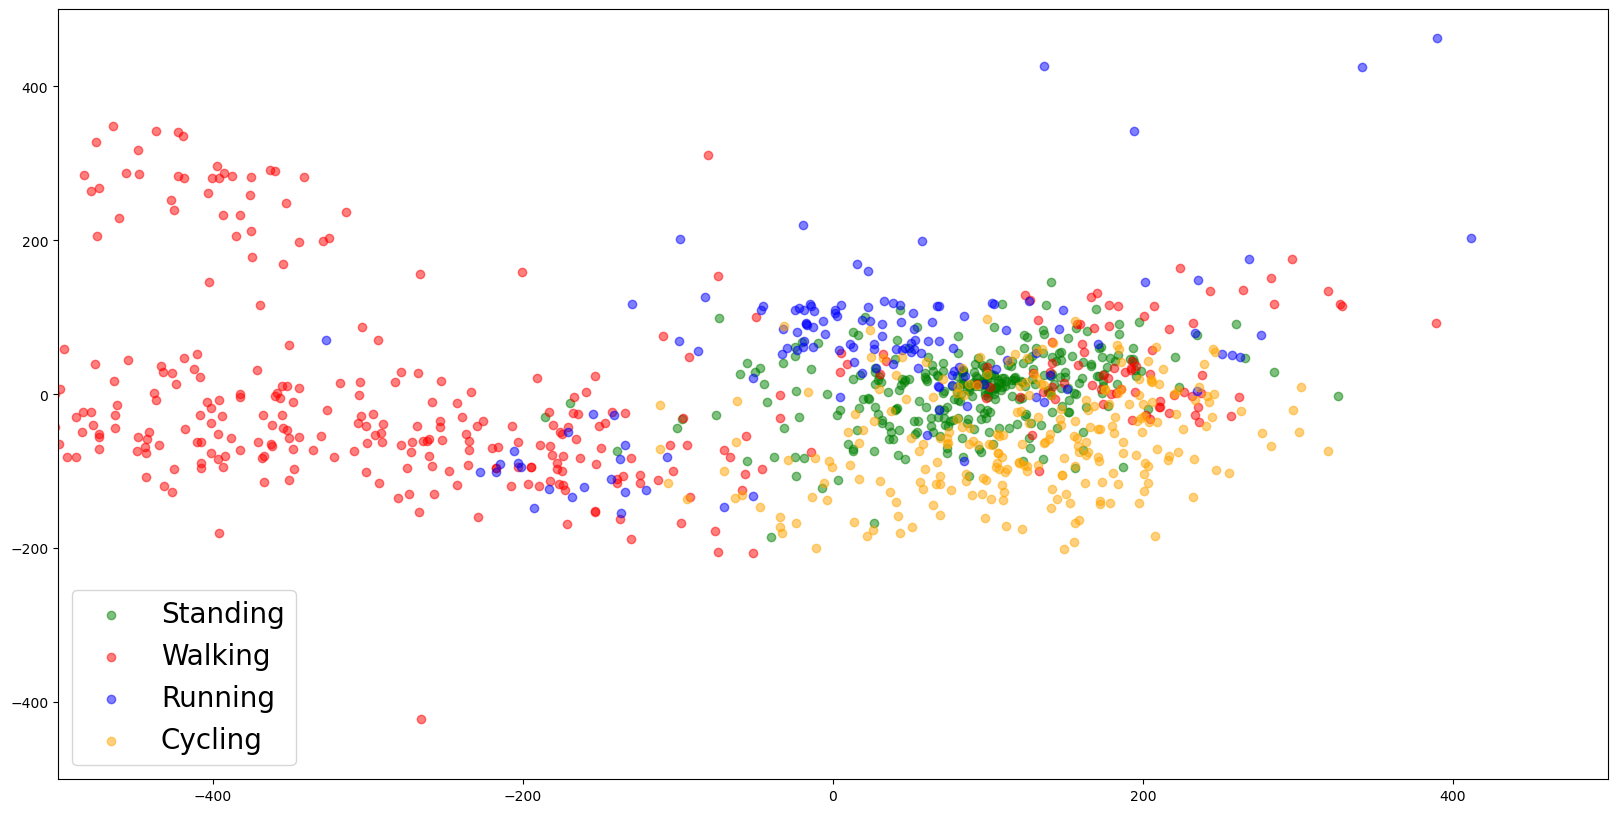

In [58]:
plt.figure(figsize = (20, 10))

X_standing = X_train_transformed[np.where(y_train == 3)]
X_walking = X_train_transformed[np.where(y_train == 4)]
X_running = X_train_transformed[np.where(y_train == 5)]
X_cycling = X_train_transformed[np.where(y_train == 6)]

X_standing_test = X_test_transformed[np.where(y_test == 3)]
X_walking_test = X_test_transformed[np.where(y_test == 4)]
X_running_test = X_test_transformed[np.where(y_test == 5)]
X_cycling_test = X_test_transformed[np.where(y_test == 6)]


plt.xlim(-500,500)
plt.ylim(-500,500)

plt.scatter(X_standing[:, 1], X_standing[:, 16], alpha = 0.5, color = "green", label = "Standing")
plt.scatter(X_walking[:, 1], X_walking[:, 16], alpha = 0.5, color = 'red', label = "Walking")
plt.scatter(X_running[:, 1], X_running[:, 16], alpha = 0.5, color = 'blue', label = "Running")
plt.scatter(X_cycling[:, 1], X_cycling[:, 16], alpha = 0.5, color = 'orange', label = "Cycling")

#plt.scatter(X_standing_test[:, 0], X_standing_test[:, 5], alpha = 0.5, color = "green")
#plt.scatter(X_walking_test[:, 0], X_walking_test[:, 5], alpha = 0.5, color = 'red')
#plt.scatter(X_running_test[:, 0], X_running_test[:, 5], alpha = 0.5, color = 'blue')
#plt.scatter(X_cycling_test[:, 0], X_cycling_test[:, 5], alpha = 0.5, color = 'orange')

plt.legend(fontsize = 20)
plt.savefig(Path("code/figures", "Data.png"))
plt.show()

Уже по двум параметрам наиболее непохожие активности хорошо разделяются

Исследуем выборку и посмотрим насколько хорошо разделяются данные по трем главным параметрам для основных активностей

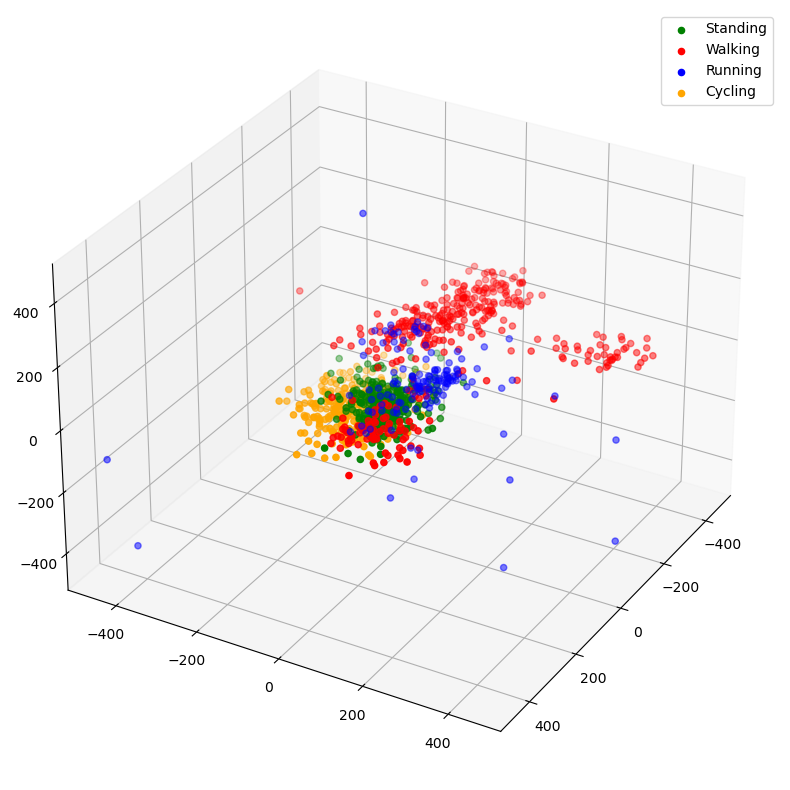

In [60]:
fig = plt.figure(figsize = (20, 10))
ax = fig.add_subplot(111, projection='3d')

ax.set_xlim(-500,500)
ax.set_ylim(-500,500)
ax.set_zlim(-500,500)


X_standing = X_train_transformed[np.where(y_train == 3)]
X_walking = X_train_transformed[np.where(y_train == 4)]
X_running = X_train_transformed[np.where(y_train == 5)]
X_cycling = X_train_transformed[np.where(y_train == 6)]

X_standing_test = X_test_transformed[np.where(y_test == 3)]
X_walking_test = X_test_transformed[np.where(y_test == 4)]
X_running_test = X_test_transformed[np.where(y_test == 5)]
X_cycling_test = X_test_transformed[np.where(y_test == 6)]

ax.scatter(X_standing[:, 1], X_standing[:, 16], X_standing[:, 6], color="green", label = "Standing")
ax.scatter(X_walking[:, 1], X_walking[:, 16], X_walking[:, 6], color="red", label = "Walking")
ax.scatter(X_running[:, 1], X_running[:, 16], X_running[:, 6], color="blue", label = "Running")
ax.scatter(X_cycling[:, 1], X_cycling[:, 16], X_cycling[:, 6], color="orange", label = "Cycling")

#ax.scatter(X_standing_test[:, 0], X_standing_test[:, 1], X_standing_test[:, 5], alpha = 0.5, color = "green")
#ax.scatter(X_walking_test[:, 0], X_walking_test[:, 1], X_walking_test[:, 5], alpha = 0.5, color = 'red')
#ax.scatter(X_running_test[:, 0], X_running_test[:, 1], X_running_test[:, 5], alpha = 0.5, color = 'blue')
#ax.scatter(X_cycling_test[:, 0], X_cycling_test[:, 1], X_cycling_test[:, 5], alpha = 0.5, color = 'orange')
ax.view_init(30, 30)
plt.legend(fontsize = 10)
plt.savefig(Path("code/figures", "Data_3D.png"))
plt.show()

По трем главным параметрам большинство активностей разделимы

In [61]:
X_train_transformed,  X_test_transformed = code.trajectories_classifing.transform_data(X_train, X_test, 20)

In [64]:
X_train_transformed.shape

(1076, 20)

In [65]:
X_test_transformed.shape

(269, 20)

Теперь применим несколько алгоритмов классификации, чтобы найти лучший

Логистическая регрессия

In [66]:
regression = LogisticRegression(C=1.0)
regression.fit(X_train_transformed, y_train)

y_pred = regression.predict(X_test_transformed)
acc_score = accuracy_score(y_test, y_pred)

/home/sasha/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [67]:
acc_score

0.862453531598513

Гауссовский процесс

In [70]:
gpc = GaussianProcessClassifier(kernel=1.0 * RBF(7), random_state=random_state)
gpc.fit(X_train_transformed, y_train)

y_pred = gpc.predict(X_test_transformed)
acc_score = accuracy_score(y_test, y_pred)

In [71]:
acc_score

0.9330855018587361

Случайный лес

In [72]:
forest = RandomForestClassifier(n_estimators=10000)
forest.fit(X_train_transformed, y_train)

y_pred = forest.predict(X_test_transformed)
acc_score = accuracy_score(y_test, y_pred)

In [73]:
acc_score

0.9144981412639405

К-ближайших соседей

In [74]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
knn.fit(X_train_transformed, y_train)
y_pred = knn.predict(X_test_transformed)
acc_score = accuracy_score(y_test, y_pred)

In [75]:
acc_score

0.8996282527881041

SVC с гауссовским ядром

In [76]:
from sklearn import svm
#svc = svm.SVC(kernel='linear')
svc = svm.SVC(kernel=RBF(5))
svc.fit(X_train_transformed, y_train)
y_pred = svc.predict(X_test_transformed)
acc_score = accuracy_score(y_pred, y_test)

In [77]:
y_pred.shape

(269,)

In [78]:
print(acc_score)

0.42379182156133827


Исследуем как ведут себя эти методы для разного количества главных компонент

In [79]:
x, y_1, y_2, y_3, y_4, y_train_1, y_train_2, y_train_3, y_train_4 =  code.trajectories_classifing.compareClassifiresperPCA(1, 100, X_train, X_test, y_train, y_test , random_state)

100%|██████████| 99/99 [16:13<00:00,  9.83s/it]


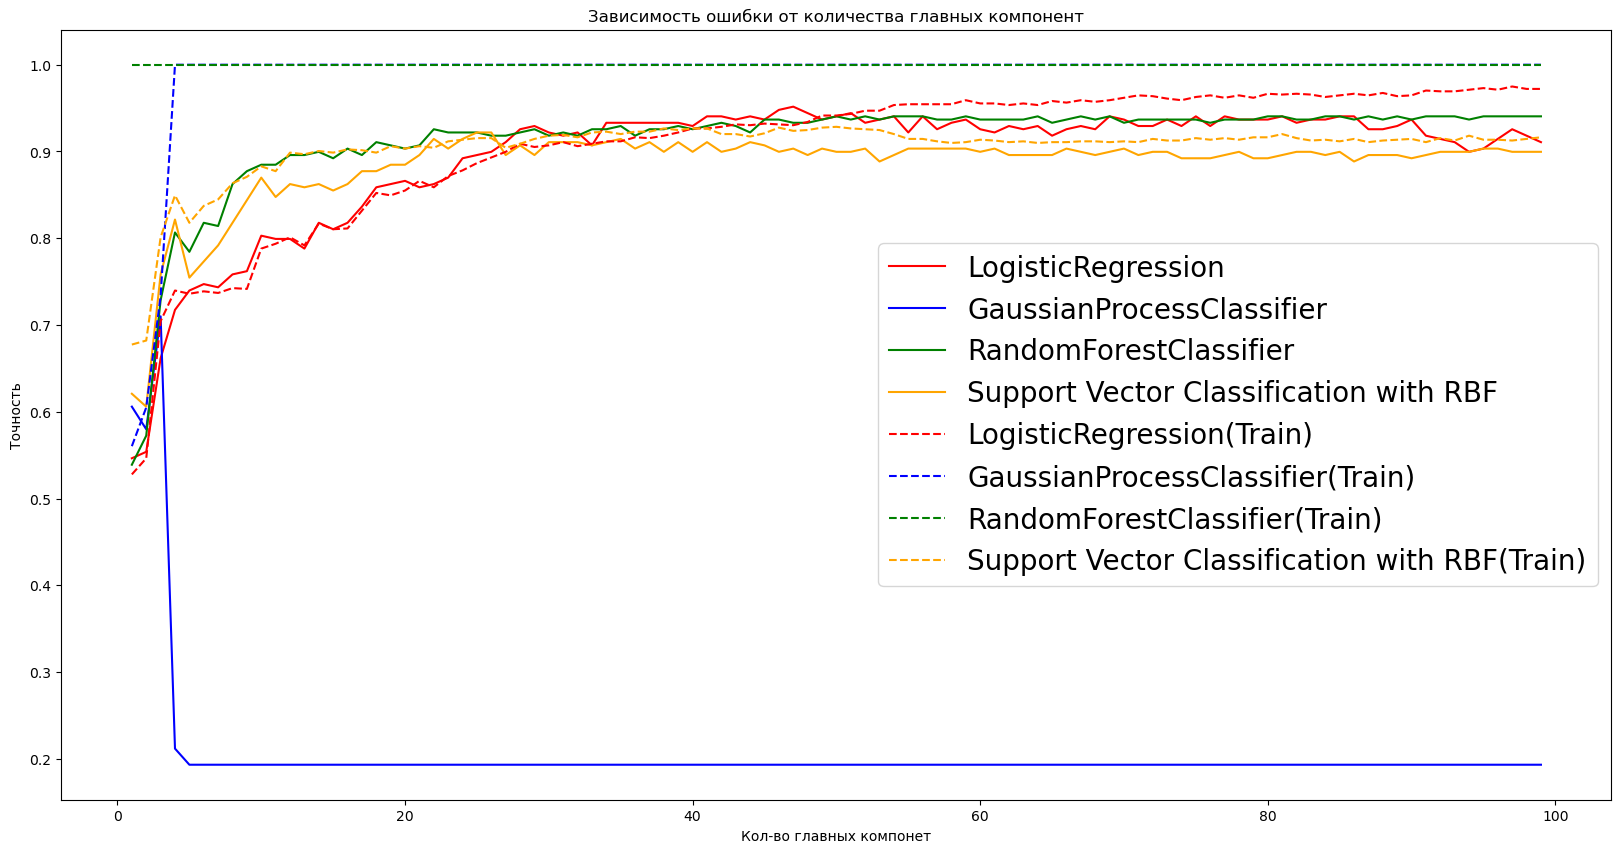

In [80]:
plt.figure(figsize = (20, 10))
plt.plot(x, y_1, color="red", label = "LogisticRegression")
plt.plot(x, y_2, color="blue", label = "GaussianProcessClassifier")
plt.plot(x, y_3, color="green", label = "RandomForestClassifier")
plt.plot(x, y_4, color="orange", label = "Support Vector Classification with RBF")
plt.plot(x, y_train_1, color="red", linestyle = '--',   label = "LogisticRegression(Train)")
plt.plot(x, y_train_2, color="blue", linestyle = '--', label = "GaussianProcessClassifier(Train)")
plt.plot(x, y_train_3, color="green", linestyle = '--', label = "RandomForestClassifier(Train)")
plt.plot(x, y_train_4, color="orange", linestyle = '--', label = "Support Vector Classification with RBF(Train)")
plt.xlabel("Кол-во главных компонет")
plt.ylabel("Точность")
plt.title("Зависимость ошибки от количества главных компонент")
plt.legend(fontsize = 20)
plt.savefig(Path("code/figures", "Accuracy.png"))
plt.show()

Стабильнее всего обучается SVC на нем остутствует переобучение и он показывает результаты сравнимые с остальными классификаторами, гауссовская переобучается, поэтому абслоютно не подходит под модель. Очень хорошо показывает себя случайный лес, что ожидаемо, т.к. модель данных сложная

###  Случайный лес

Окончательно выберем случайный лес и построим классификатор на его основе

In [51]:
X_train_transformed,  X_test_transformed = code.trajectories_classifing.transform_data(X_train, X_test, 50)

In [109]:
forest = RandomForestClassifier(n_estimators=300)
forest.fit(X_train_transformed, y_train)

y_pred = forest.predict(X_test_transformed)
acc_score = accuracy_score(y_test, y_pred)

In [110]:
acc_score 

0.9479553903345725

LNN-классификтор показывает результат в 94%, что подтверждает нашу гипотезу о том, что лагранжианы лежат в разных классах для разных действий

###  Наивный метод

Для сравнения приведем результаты классификации траекторий "наивным" методом

In [20]:
X_series = []
a = 500
for i in range(0, len(all_velocities)):
    X_series.append(all_velocities[i][:a][1])
X_series = np.array(X_series)
y = np.array(targets)

In [21]:
X_series.shape

(1372, 9)

In [27]:
print(np.where(y == 3)[0].shape)
print(np.where(y == 4)[0].shape)
print(np.where(y == 5)[0].shape)
print(np.where(y == 6)[0].shape)

(377,)
(475,)
(194,)
(326,)


In [30]:

from sklearn.model_selection import GridSearchCV

from sktime.classification.interval_based import TimeSeriesForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

X_train, X_test, y_train, y_test = train_test_split(X_series, y)
classifier = TimeSeriesForestClassifier(n_estimators=100)
classifier.fit(X_train, y_train)
param_grid = {"n_estimators": np.linspace(1, 10, 100, dtype = int)}
grid = GridSearchCV(classifier, param_grid=param_grid, cv=3)
grid.fit(X_train, y_train)
y_pred = grid.predict(X_test)
print(accuracy_score(y_test, y_pred))

0.7871720116618076


Результат в 78% намного меньше чем у LNN-классификатора